# **Varational Autoencoders on MNIST**
A tutorial on training a VAE to reconstruct and generate MNIST digits! This is my implementation of the 2013 paper ***Auto-Encoding Variational Bayes***, which you can read [here](https://arxiv.org/abs/1312.6114). I'll try my best to explain the underlying concepts that allow the Variational Autoencoder to work!

## **What Is a Variational Autoencoder?**

Simply put, a Variational Autoencoder (VAE) can compress and decompress data. 

It takes an input and maps it to a smaller latent space. The latent space can then be decoded to reconstruct the original input. For example, a typical MNIST image is 28px x 28px. This is a **784-pixel image.** The VAE can map this 784-pixel image to a latent vector of just *five numbers.* Impressive, right?

To do this, though, the VAE requires a couple of tricks. All of the necessary tricks will be discussed in-depth in this notebook.

In [23]:
#@title ***Imports***
#@markdown Run this cell to download all the necessary libraries.
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [24]:
# fill in any necessary hyperparameters

# if you want to train a VAE from scratch, set this to False
load_model = True
# how many times the model will process the dataset
epochs = 1000
# in the form of (input, hidden, latent space)
layer_dims = (784, 1024, 2)
# how many examples will be sent through the VAE at once
batch_size = 2048
# path to save/load the files
path = 'vae-trained'

In [25]:
# run this cell to download the dataset

trainloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=batch_size, shuffle=True)

testloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=batch_size, shuffle=True)

Original paper uses TanH, we use ReLU

## **The VAE Network Architecture**



In [26]:
class VariationalAutoEncoder(nn.Module):

  def __init__(self, input_size, hidden_size, latent_size):
    
    super(VariationalAutoEncoder, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.latent_size = latent_size 
    
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.h1 = nn.Linear(hidden_size, hidden_size)
    
    self.mu = nn.Linear(hidden_size, latent_size)
    self.logvar = nn.Linear(hidden_size, latent_size)

    self.fc2 = nn.Linear(latent_size, hidden_size)
    self.h2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, input_size)
    self.sigmoid = nn.Sigmoid()
    
    self.criterion = nn.BCELoss(reduction='sum')
    self.optim = optim.Adam(self.parameters())
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.to(self.device)
  
  def encode(self, x):
    # start by encoding an input image
    x = F.relu(self.fc1(x))
    # send thru hidden layer
    x = F.relu(self.h1(x))
    # get the mu and log variance vectors 
    mu = self.mu(x)
    logvar = self.logvar(x)

    return mu, logvar

  def decode(self, z):
    # send through the decoder portion
    x = self.fc2(z)
    # send through hidden layer
    x = F.relu(self.h2(x))
    # activate final layer with a sigmoid, as we are using the Bernoulli variant
    x = self.sigmoid(self.fc3(x))

    return x

  def forward(self, x):
    # send through encoder
    mu, logvar = self.encode(x)
    # do the reparameterization trick 
    z = self.reparameterize(mu, logvar)
    # send through decoder
    x = self.decode(z)
    
    return x, mu, logvar

  def reparameterize(self, mu, logvar):

    sigma = torch.exp(0.5 * logvar)
    epsilon = torch.randn_like(sigma)

    return mu + sigma * epsilon

In [27]:
VAE = VariationalAutoEncoder(*layer_dims)

if load_model:
  VAE.load_state_dict(torch.load(path))

In [28]:
if not load_model:
  for e in range(epochs):

    VAE.train()
    train_loss = 0

    for images, labels in trainloader:
      # zero the gradient
      VAE.optim.zero_grad()
      # flatten inputs before sending them through VAE
      img = images.view(images.size()[0], -1).to(VAE.device)
      # get outputs from network
      out, mu, logvar = VAE(img)
      # compute reconstruction loss, KL Divergence Factor
      bce_loss = VAE.criterion(out, img)
      D_KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
      loss = bce_loss + D_KL
      # accumulate loss
      train_loss += loss.item()
      # backpropagate and perform an optimization step
      loss.backward()
      VAE.optim.step()

    print('Epoch: %.0f' % e, '| Train Loss: %.3f' % train_loss)

  torch.save(VAE.state_dict(), 'vae-trained')

In [29]:
with torch.no_grad():

  test_img, label = next(iter(testloader))
  test_img = test_img[0]
  test_img = test_img.view(test_img.size(0), -1).to(VAE.device)

  out, mu, logvar = VAE(test_img)

  

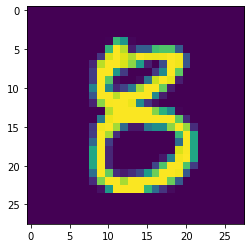

In [30]:
plt.imshow(test_img.cpu().numpy().reshape(28, 28))

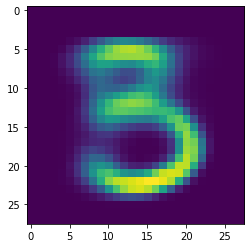

In [31]:
plt.imshow(out.cpu().numpy().reshape(28, 28))

In [32]:
def generate():

  rand_sample = torch.randn(64, 2).to(VAE.device)

  out = VAE.decode(rand_sample).detach().cpu().numpy()
  fig = plt.figure(figsize=(8,8))

  for _ in range(64):

    fig.add_subplot(8, 8, _+1)
    plt.imshow(out[_].reshape(28, 28))
  
  return out

In [33]:
# plot_latent function taken from https://savadikarc.github.io/post/2020/01/30/vae_vis/ 

def plot_latent(samples_per_class=5000):

  fig = plt.figure(figsize=(10,10))

  for digit in range(10):

    img, labels = next(iter(trainloader))

    X = img[labels == digit]
    y = labels[labels == digit]

    indices=np.random.permutation(np.arange(X.shape[0]))
    X = X[indices]

    X_sample = X.float().view(X.size()[0], X.size()[1], -1).to(VAE.device)

    mu, logvar = VAE.encode(X_sample)
    z = VAE.reparameterize(mu, logvar).detach().cpu().numpy()
    z = z.reshape(z.shape[0], z.shape[-1])


    plt.scatter(z[:, 0], z[:, 1], c=None, alpha=0.7)

  plt.legend([_ for _ in range(10)])
  plt.xlabel('z1')
  plt.ylabel('z2')
  plt.show()


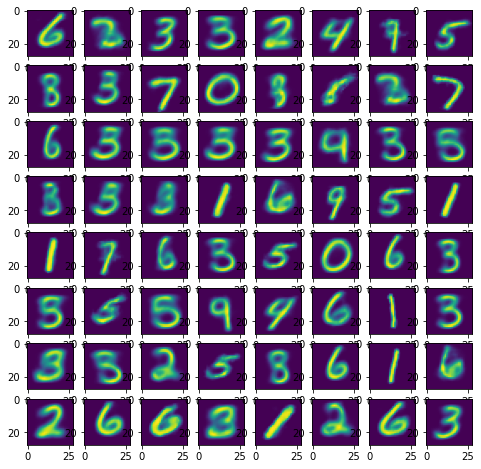

In [34]:
out = generate()

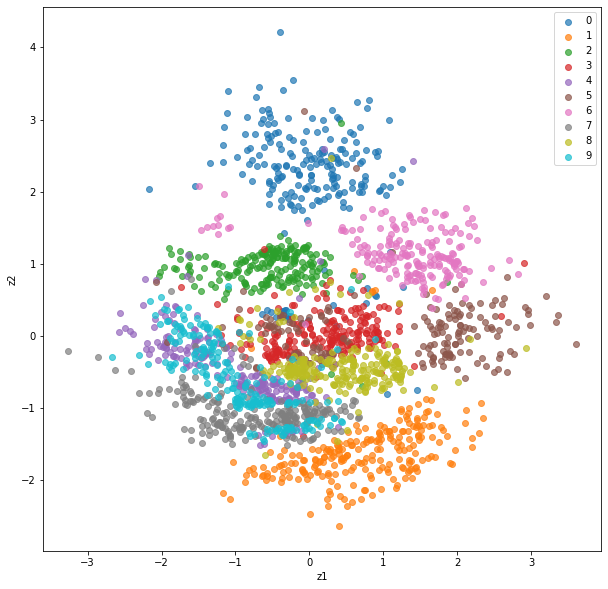

In [35]:
plot_latent()

In [62]:
random_vec = torch.tensor([1.9, 1.7]).to(VAE.device)

out = VAE.decode(random_vec)

In [63]:
out = out.detach().cpu().numpy()

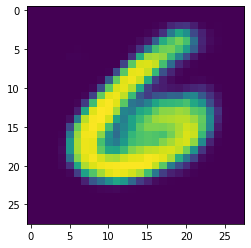

In [64]:
plt.imshow(out.reshape(28, 28))

In [65]:
print(random_vec)

tensor([1.9000, 1.7000], device='cuda:0')
